# Classifying Images with a Linear Model

In this notebook, you learn how to classify images of flowers with a linear model using the tf.keras API.

## Learning Objectives
1. Examine and understand the data.
2. Implement a linear model using the Keras API.
3. Plot the predictions.

In [1]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
import tensorflow as tf
print(tf.version.VERSION)

2.6.5


In [2]:
!pip install pydot
!sudo apt-get update
!sudo apt-get install graphviz -y

Hit:1 https://packages.cloud.google.com/apt gcsfuse-bullseye InRelease
Hit:2 https://download.docker.com/linux/debian bullseye InRelease              
Get:3 https://nvidia.github.io/libnvidia-container/stable/debian10/amd64  InRelease [1484 B]
Hit:4 https://nvidia.github.io/nvidia-container-runtime/stable/debian10/amd64  InRelease
Hit:5 https://packages.cloud.google.com/apt google-compute-engine-bullseye-stable InRelease
Hit:6 https://nvidia.github.io/nvidia-docker/debian10/amd64  InRelease        
Hit:7 https://packages.cloud.google.com/apt cloud-sdk-bullseye InRelease      
Hit:8 https://packages.cloud.google.com/apt google-fast-socket InRelease      
Hit:9 https://deb.debian.org/debian bullseye InRelease
Hit:10 https://deb.debian.org/debian-security bullseye-security InRelease
Hit:11 https://deb.debian.org/debian bullseye-updates InRelease
Hit:12 https://deb.debian.org/debian bullseye-backports InRelease
Fetched 1484 B in 2s (976 B/s)
Reading package lists... Done
Reading package li

## Let's examine the dataset

You will be using a creative-commons licensed [flower photo dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) of 3670 images falling into 5 categories:

* daisy
* roses
* dandelion
* sunflowers
* tulips

The images to be used in this notebook are already prepared and stored in a public bucket  in Google Cloud Storage:

<pre>
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/.
</pre>

Let's see the first five lines of the train_set.csv You'll notice that each line consists of a JPEG filename and the type of flower it is.


In [3]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/4933229095

The images are listed in CSV files and randomly split into a training (90% of images) and an evaluation (10% of images) datasets. This split helps you from a generalization and reproducibility perspective.

In order to train image models, we need to read image data into our programs. There are four steps to reading an image in a standard format like JPEG or PNG and getting it ready to train machine learning models with it.

Training set: [gs://cloud-ml-data/img/flower_photos/train_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv)

Evaluation set: [gs://cloud-ml-data/img/flower_photos/eval_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv)

### Reading and decoding the image data

In order to train image models, you need to read image data into your programs. [tf.io](https://www.tensorflow.org/api_docs/python/tf/io) and [tf.image](https://www.tensorflow.org/api_docs/python/tf/image) modules contain various functions for image processing and decoding-encoding Ops.

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2024-08-11 10:17:02.227326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-08-11 10:17:02.227436: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-11 10:17:02.227468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240811-150205): /proc/driver/nvidia/version does not exist
2024-08-11 10:17:02.227998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Visualizing image data

Visualizing the image is useful to get a sense of how challenging a problem is. To visualize the image, use Matplotlib’s imshow() function, but first convert the image, which is a TensorFlow tensor format, into a numpy array using the numpy() function.

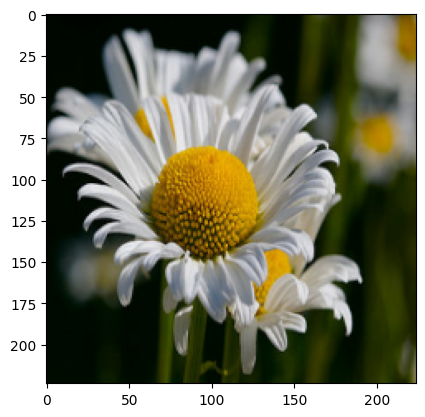

In [5]:
# Try reading and displaying one of the files
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow((img.numpy()));

show_image(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

In order to train a machine model, though, you need to read many images. You also need to obtain the labels for each of the images. Obtain a list of all the images by carrying out a wildcard match using glob():

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


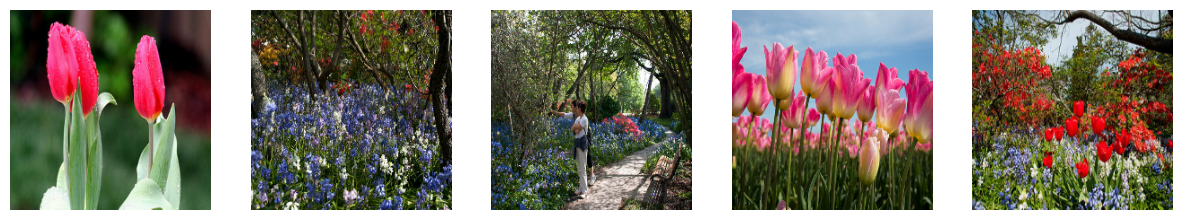

In [6]:
# notice that the file name has the flower type in it. Let's look at a few tulips
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

The images in your dataset have a naming convention. Therefore, you can take a filename and extract the label using string operations. For example, you can remove the prefix and get the category name using split():

In [7]:
tf.strings.split(tf.strings.regex_replace(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", ""),
    '/')[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

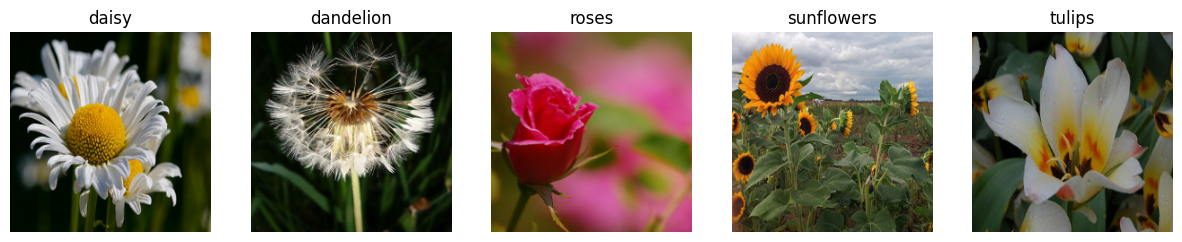

In [8]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].axis('off')

Training and evaluation datasets are comma-separated value (CSV) files. Each line in those files contains the filename followed by the label. Therefore, you don’t need to parse the filename to obtain the label. One way to read the CSV file is to read in text lines using **TextLineDataset**, passing in a function to handle each line as it is read through the map() function.

Use tf.data API to handle large amounts of data (even if it doesn’t all fit into memory), by reading only a handful of data elements at a time, and performing transformations as you are reading the data.

The tf.data API does this by using an abstraction called tf.data.Dataset to represent a sequence of elements. In our pipeline, each element is a training example that contains two tensors. The first tensor is the image and the second tensor is the label. There are many types of Datasets corresponding to many different file formats. We are using **TextLineDataset** which reads text files and assumes that each line is a different element.

The parse_csvline function is a function that we supply in order to parse the line, extract the filename of the image, read the image and return the image and its label.

The record_defaults that are passed into the parse_csvline function specify what TensorFlow needs to replace with in order to handle a line where one or more values are missing.

In [9]:
def parse_csvline(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(parse_csvline)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(parse_csvline)).batch(10)

## A linear model

A higher-level abstraction, such as a sequential API in Keras,  is easier to use rather than write equations using low-level TensorFlow functions. The sequential API allows you to create models layer-by-layer for most problems. A linear model which can be represented in Keras by tf.keras.Sequential() means that the model consists of “layers” that are connected such that the output of one layer is the input to the next.

In [10]:
# Implement a linear model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)),
    tf.keras.layers.Dense(len(CLASS_NAMES),activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

You can view the model using utils(). This yields the diagram below. Note that the input layer takes a batch (that’s the None) of [224, 224, 3] images. None represents that its dimension size is undefined until runtime. This way the model can dynamically adapt to any batch size.The Flatten layer takes this input and returns a batch of 224 224 3 = 150528 numbers that are then connected to 5 outputs in the Dense layer.

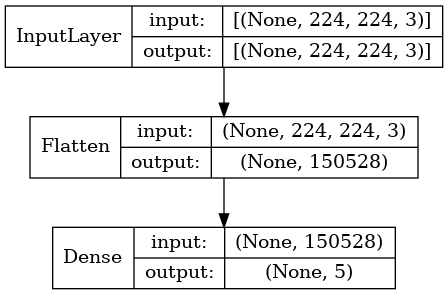

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

You can verify that the Flatten operation does not need any trainable weights, but the Dense layer involves 150528x5=752645 weights that need to be trained by using model.summary()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In order to use the Keras model defined above, call model.fit() with the training dataset and model.predict() with each image you want to classify. To train the model, you need to tell Keras how to optimize the weights based on the training dataset. The way to do this is to compile the model, specifying an optimizer to use, the loss to minimize, and metrics to report.

In [ ]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10


2024-08-11 10:17:05.408366: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


330/330 [==============================] - 73s 220ms/step - loss: 16.5026 - accuracy: 0.3464 - val_loss: 22.5058 - val_accuracy: 0.3405
Epoch 2/10
330/330 [==============================] - 72s 218ms/step - loss: 14.7167 - accuracy: 0.4139 - val_loss: 20.6250 - val_accuracy: 0.3865
Epoch 3/10
330/330 [==============================] - 72s 218ms/step - loss: 13.1672 - accuracy: 0.4458 - val_loss: 20.2543 - val_accuracy: 0.3865
Epoch 4/10
330/330 [==============================] - 83s 252ms/step - loss: 12.5788 - accuracy: 0.4952 - val_loss: 16.9232 - val_accuracy: 0.4108
Epoch 5/10
330/330 [==============================] - 77s 231ms/step - loss: 11.3257 - accuracy: 0.5239 - val_loss: 25.0860 - val_accuracy: 0.3865
Epoch 6/10
330/330 [==============================] - 75s 227ms/step - loss: 12.6968 - accuracy: 0.5130 - val_loss: 26.6544 - val_accuracy: 0.4054
Epoch 7/10
330/330 [==============================] - 74s 225ms/step - loss: 13.2490 - accuracy: 0.5373 - val_loss: 18.8621 - val

An epoch is a full pass through the dataset. You are asking the optimizer to go through the training data 10 times in the previous cell. 10 epochs might be sufficient for the loss to converge. In ordr to verify this you can plot the history of the loss and error metrics. You can then plot the loss and validation loss using the training_plot function.

This yields the graph shown below. Note that the loss does not go down smoothly; instead, it is quite choppy. This is an indication that batch size and optimizer settings can be improved. The validation loss goes down, and then starts to increase. This is an indication that _overfitting_ is starting to happen – the network has started to memorize details of the training dataset (such details are called noise) that do not occur in the validation dataset. Either 10 epochs is too long, or we need to add _regularization_.

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

In [ ]:
training_plot(['loss', 'accuracy'], history);

When building classification models, it is important to understand several concepts related to probabilities because the output of a classification model is a probability – the likelihood that an event will occur. The logit is the natural logarithm of the odds of the event happening. Thus, for an event with probability=0.25, the logit is log(0.25/0.75) or -1.098. For an event with a probability=0.75, the logit is 1.098. As the probability goes to zero, the logit goes to -infinity and as the probability goes to one, the logit goes to +infinity. Therefore, the logit occupies the entire space of real numbers, as shown below:

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y);
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

The softmax function is nonlinear and has the effect of squashing low values and boosting the maximum, as shown in figure below. Note that the sum of the probabilities in both instances adds up to 1.0.

In [ ]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print(prob.numpy(), softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()

## Getting Predictions
The Keras predict() function will do the model computation on the image. Because the model has the trained set of weights in its internal state, we can compute what the predicted value for an image will be by calling model.predict() and passing in an image.

### Plotting predictions
You can look at what the model has learned by plotting the predictions of the model on a few images from the training dataset by using plot_predictions(). Note that you need to take the single image and make it a batch because the model was trained on a batch not a single image. The first few predictions from the training and evaluation datasets are shown in the graph.

In [ ]:
# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(parse_csvline))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

First few images from the training datasets:

In [ ]:
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")

In [ ]:
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")

In [ ]:
def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

show_trained_weights(model)